In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

### Leitura do dataframe

In [2]:
from config import DF_TRAIN

In [3]:
df = pd.read_csv(DF_TRAIN)

### Analisando o dataframe

In [4]:
df.head(10)

,id,comment_text,Toxic
0,0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,Toxic
1,006e87872c8b370c,you are a stupid fuck \n\nand your mother's cu...,Toxic
2,00b77cb600c897b4,"""\n\nAnd you are? Let me know when you've craw...",Toxic
3,00c0b8ed05ed7833,Fuck off\n\nYou are NOT an administrator. You ...,Toxic
4,00d7a73eb033ee5e,"Have you seen the reference to their claim, yo...",Toxic
5,011d0c0a6c8e5765,I NEVER FUCKING MADE THIS MOTHER FUCKING ARTIC...,Toxic
6,0122aba9f97885cd,There are many broken nostrils in this pancreas,Non-Toxic
7,016aa1af4fa90e8b,"""\n\nElvis... Crying in the Chapel Feudalist """,Non-Toxic
8,019ab9a91e7fcdbe,Are you fucker mother fucker have nothing to d...,Toxic
9,01ce75675a501e50,"""\\nYou wasted your own time! Take this advice...",Toxic


In [5]:
df.describe()

,id,comment_text,Toxic
count,2000,2000,2000
unique,2000,2000,2
top,0028d62e8a5629aa,All of my edits are good. Cunts like you who ...,Toxic
freq,1,1,1500


In [6]:
example = 9
print('Comment')
print('------------------------------')
print(df['comment_text'][example])
print('------------------------------')
print(df['Toxic'][example])

Comment
------------------------------
"\
You wasted your own time! Take this advice with you: Pull your head out of your ass! Be real and don't spend the rest of your life sucking ass. Have a nice life! Goodbye!  (mailbox) "
------------------------------
Toxic


### Preprocessamento

In [7]:
from nlp_preprocessing import basic_preprocessing, lemmatizer, change_words, y_encoder
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package words to /home/geovane/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/geovane/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/geovane/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/geovane/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df['Toxic'], test_size=0.33, shuffle=True)

In [9]:
dict_change = {
    'Toxic':1,
    'Non-Toxic':0
}

In [10]:
y_train, y_test = y_encoder(y_train, dict_change), y_encoder(y_test, dict_change)

In [11]:
dict_change = {
    "'re" : ' are ',
    "'is": ' is ',
    "'ve" : ' have ',
    "n't":' not ',
    "'m": ' am ',
    "'ll": ' will '
}


In [12]:
X_train, X_test = basic_preprocessing(change_words(X_train, dict_change)), basic_preprocessing(change_words(X_test, dict_change))

In [13]:
preprocessed_data = [('Basic', X_train, X_test),('& Lematizer', lemmatizer(X_train),lemmatizer(X_test))]

### Treinamento básico

In [14]:
from nlp_training import simple_training
from config import MODELS, METHODS, METRICS

In [15]:
dataframe = pd.DataFrame({})
for method in METHODS:
    for name, X_train, X_test in preprocessed_data: 
        aux = simple_training(X_train, y_train, X_test, y_test, MODELS, METRICS, method)
        aux['Preprocessing'] = name
        aux['Method'] = method
        dataframe = pd.concat([dataframe, aux], ignore_index=True)

In [16]:
dataframe.sort_values(by=['accuracy_score'], ascending=[False]).head()

,Model,accuracy_score,f1_score,precision_score,Preprocessing,Method
30,BAYES_MULTINOMIAL,0.863636,0.909091,0.903614,Basic,CountVectorizer()
41,BAYES_MULTINOMIAL,0.857576,0.904082,0.907787,& Lematizer,CountVectorizer()
27,MLP_2_layer,0.846970,0.901846,0.864060,Basic,CountVectorizer()
38,MLP_2_layer,0.846970,0.901846,0.864060,& Lematizer,CountVectorizer()
16,MLP_2_layer,0.845455,0.901354,0.859779,& Lematizer,TfidfVectorizer()


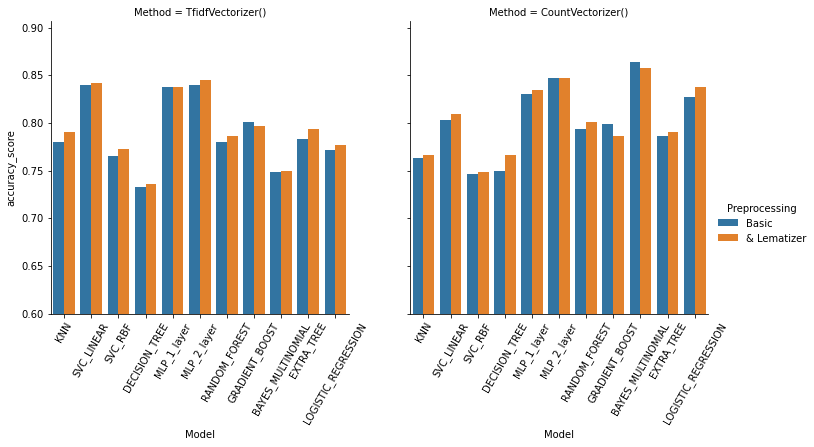

In [17]:
plot = sb.catplot(x='Model', y='accuracy_score', hue='Preprocessing', col='Method',data=dataframe, kind='bar')
plt.ylim(0.6)
for ax in plot.axes.flat:
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=60)


### Primeira análise


Lematização se saiu melhor durante a classificação, utilizarei somente ela

### Treino avançado

In [18]:
from models import Models
import random
from nlp_training import full_training

Selecionando os 3 melhores classificadores. O Multinomial bayes não entra na lista devido não ter variação de parametros

In [19]:
models = {
    Models.MLP_2_layer.name: Models.MLP_2_layer.value,
    Models.SVC_LINEAR.name: Models.SVC_LINEAR.value,
    Models.LOGISTIC_REGRESSION.name: Models.LOGISTIC_REGRESSION.value,
}

In [20]:
C = [2 ** i for i in range(-5, 16,2)]
gamma = [2 ** i for i in range(-15, 4,2)]
gamma += ['auto','scale']

In [21]:
params = {
    Models.MLP_2_layer.name: {
        'clf__hidden_layer_sizes': [(random.randrange(0, 500), random.randrange(0, 500)) for i in range(1000)],
        'clf__tol':[0.001, 0.0005, 0.0001],
        'clf__learning_rate':['constant', 'invscaling','adaptive'],
        'clf__max_iter':[1000]
    },
    Models.SVC_LINEAR.name: {
        'clf__C':C,
    },
    Models.LOGISTIC_REGRESSION.name: {
        'clf__penalty':['l2', 'none'], 
        'clf__solver':['lbfgs','newton-cg','sag', 'saga'],
        'clf__max_iter':[10000]
    },
}

In [22]:
X_train, X_test = preprocessed_data[1][1], preprocessed_data[1][2]

In [23]:
dataframe = pd.DataFrame({})
for method in METHODS:
    aux = full_training(X_train, y_train, X_test, y_test, models, params, METRICS , method, n_iter=10)
    aux['Method'] = method
    dataframe = pd.concat([dataframe, aux], ignore_index=True)

/home/geovane/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/home/geovane/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [24]:
dataframe.sort_values(by=['accuracy_score'], ascending=[False]).head()

,Model,Params,accuracy_score,f1_score,precision_score,Method
0,MLP_2_layer,"{'clf__tol': 0.0001, 'clf__max_iter': 1000, 'c...",0.853030,0.904055,0.880539,TfidfVectorizer()
3,MLP_2_layer,"{'clf__tol': 0.001, 'clf__max_iter': 1000, 'cl...",0.853030,0.904055,0.880539,CountVectorizer()
2,LOGISTIC_REGRESSION,"{'clf__solver': 'saga', 'clf__penalty': 'none'...",0.837879,0.896818,0.853211,TfidfVectorizer()
1,SVC_LINEAR,{'clf__C': 128},0.834848,0.894482,0.853974,TfidfVectorizer()
5,LOGISTIC_REGRESSION,"{'clf__solver': 'sag', 'clf__penalty': 'l2', '...",0.830303,0.893333,0.840502,CountVectorizer()


<AxesSubplot:xlabel='Model', ylabel='accuracy_score'>

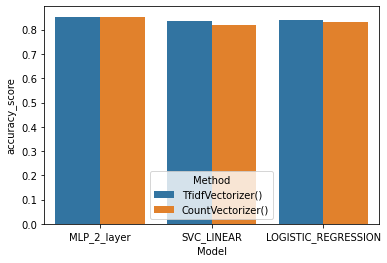

In [25]:
sb.barplot(y='accuracy_score', x = 'Model', hue='Method', data=dataframe)

### Final training

In [26]:
from nlp_training import final_training
from sklearn.metrics import accuracy_score
from random import randint
from sklearn.feature_extraction.text import CountVectorizer

In [27]:
model = Models.MLP_2_layer.value
params = {
    'clf__hidden_layer_sizes':((randint(0, 500), randint(0, 500)), (randint(500, 1000),randint(500, 1000))),
    'clf__learning_rate':['constant', 'invscaling','adaptive'],
    'clf__max_iter':[1000],
    "vectorizer__max_df": (0.5, 1.0),
    "vectorizer__ngram_range": ((1, 1), (1, 2)),
}

In [28]:
dataframe = final_training(X_train, y_train, X_test, y_test, model, params, [accuracy_score], CountVectorizer())

In [ ]:
dataframe

{'accuracy_score': 0.8454545454545455,
 'Params': Pipeline(steps=[('vectorizer', CountVectorizer(max_df=0.5)),
                 ('clf',
                  MLPClassifier(hidden_layer_sizes=(178, 270), max_iter=1000))]),
 'Estimator': Pipeline(steps=[('vectorizer', CountVectorizer(max_df=0.5)),
                 ('clf',
                  MLPClassifier(hidden_layer_sizes=(178, 270), max_iter=1000))])}

### Saving the params of model in json archive

In [ ]:
import json

In [ ]:
f = open("model.txt", "a")
f.write(dataframe.__str__())
f.close()